# Path

In [7]:
HEAD_PATH = './'
DATA_PATH = HEAD_PATH + "data/stocks/"
SAVE_PATH = HEAD_PATH + "ckpt/"    # most of signal timeseries is here
TEMP_PATH = SAVE_PATH + "tmp pkl/"
OUTPUT_PATH = HEAD_PATH + 'output'

# signal result atr: signal evaluate results


- in our original agenda this week we try different covariance estimation method
- but I think we'd better go directly to regression model
- then we can save some time for further more complicate machine learning models


- this week we focus on the most simple linear regression without regularization

In [8]:
from stock_helper import *
from stock_stats import *
from imp import reload   
import stock_helper
import stock_stats
reload(stock_helper)
reload(stock_stats)
import os

import  sklearn.preprocessing
import statsmodels.formula.api as smf

In [9]:
# CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM = 10

In [10]:
import warnings
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')

- number of cores, set this number according to your computer

- sample period

In [11]:
period = 4096
product_list = ["600519", "000858", "000568", "600809", "002304"]

- get all of the days

In [12]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)

In [13]:
# os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

In [14]:
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002", "ret.4096.004"])

array(['nr.4096', 'dbook.4096', 'range.pos.4096', 'price.osci.4096',
       'ma.dif.10.4096', 'kdj.k.4096', 'kdj.j.4096', 'nr.range.4096',
       'dbook.range.4096', 'range.pos.range.4096',
       'price.osci.range.4096', 'ma.dif.10.range.4096',
       'kdj.k.range.4096', 'kdj.j.range.4096', 'nr.std.4096',
       'dbook.std.4096', 'range.pos.std.4096', 'price.osci.std.4096',
       'ma.dif.10.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
       'nr.trend.index.4096', 'dbook.trend.index.4096',
       'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
       'ma.dif.10.trend.index.4096', 'kdj.k.trend.index.4096',
       'kdj.j.trend.index.4096', 'ret.4096', 'ret.4096.001',
       'ret.4096.002', 'ret.4096.004'], dtype='<U27')

In [15]:
len(signal_list)

28

In [16]:
all_dates[0]

'2011.pkl'

In [17]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[0])
data = data.reset_index(drop=True)

- let's begin with week 7 

- to build up a regression model, we need predictors and response variables
- the previous signals can be predictors
- now we need to create a response

- for example, we can use future log returns as response

- here fcum means the future sum of data
- for example

In [18]:
data.columns

Index(['date.time', 'price', 'traded.num', 'turnover', 'qty', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5',
       'bid1.qty', 'bid2.qty', 'bid3.qty', 'bid4.qty', 'bid5.qty', 'ask1.qty',
       'ask2.qty', 'ask3.qty', 'ask4.qty', 'ask5.qty', 'adjust', 'wpr',
       'next.bid', 'next.ask', 'wpr.ret', 'ret', 'min.4096', 'max.4096'],
      dtype='object')

3.1077846631663104

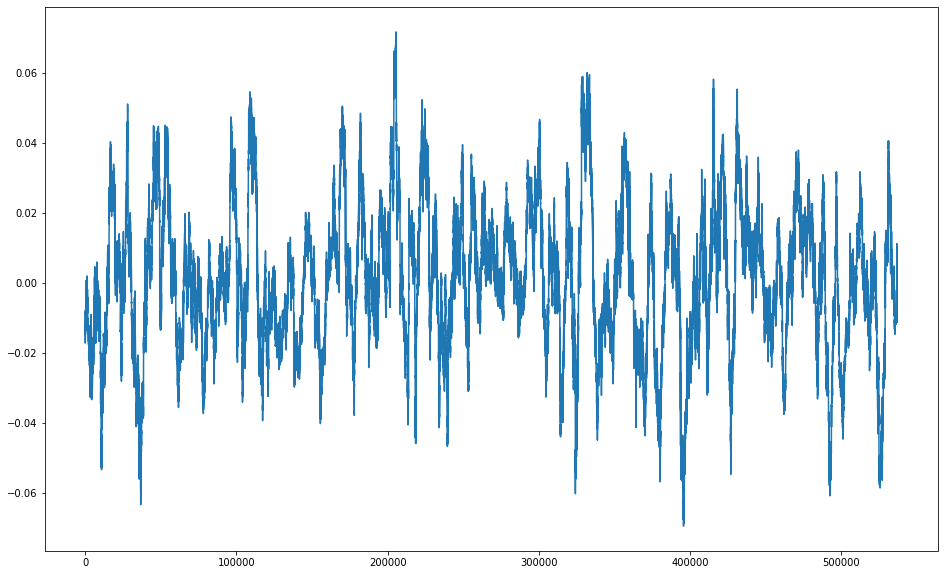

In [19]:
sample_y = fcum(data["ret"], period)

plt.figure(1, figsize=(16, 10))
plt.plot(sample_y.values)

kurtosis(sample_y, fisher=False)
## 3.1077846631663086

- the response has quite high kurtosis, it means the response has fat tails


- we can check the result

In [20]:
np.sum(data["ret"][3000:(3000+period)])
## -0.022059289468760568

-0.022059289468760568

In [21]:
sample_y[2999]

-0.022059289468760568

- so fcum means future sume, and ys is the future price return

- now we create directory for this response signal

# Functions

In [22]:
## parallel generate the distribution of a signal
def par_get_all_signal(signal_name, file_list, product, period, SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file) ## signal
#         good = load(SAVE_PATH+"/good pkl/"+product+"/"+file) ## good singal
#         signal = S[good]
        signal = S
        moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product+"."+signal_name+".pkl")

    
# calc pnl given a signal
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                   max_spread=0.011,
                   HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, atr_filter=0):
    ## load data
    data = load(DATA_PATH+product+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    atr = load(SAVE_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)

    cur_spread = data["ask1"]-data["bid1"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        #change_pos = position - position.shift(1)
        #notional_change_pos = notional_position-notional_position.shift(1)
        change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        #notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = data["next.ask"][change_buy]*(1+buy_tranct)*data["adjust"]
        change_base[change_sell] = data["next.bid"][change_sell]*(1-sell_tranct)*data["adjust"]
        raw_pnl = -(change_base*change_pos).cumsum()+notional_position*data["wpr"]
        final_pnl = -sum(change_base*change_pos) ## total pnl, there is a negative sign, because selling get money and buying pay money
        turnover = sum(change_base*abs(change_pos))
        num = sum((position!=0) & (change_pos!=0)) ## number of trades
        hld_period = sum(position!=0)   ## holding period
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, final_pnl/num, final_pnl)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])

    
from collections import OrderedDict
def get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str="2018", reverse=1, 
                     atr_filter=0, HEAD_PATH="d:/intern", SAVE_PATH="d:/intern"):
    train_sample = all_dates<split_str ## training samples
    test_sample = all_dates>split_str ## testing samples
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0] ## get training result
    train_stat = get_hft_summary(train_result, thre_mat) ## get training result statistics
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0] ## get testing result
    test_stat = get_hft_summary(test_result, thre_mat) ## get testing result statistics
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])

    
def evaluate_signal(signal, all_dates, product, min_pnl, min_num, 
                    CORE_NUM, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern", period=4096, split_str="2018", 
                    atr_filter=0, save_path="signal result",reverse=0):
    signal_name = signal+"."+str(period) ## signal name, with period
    all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+signal_name+".pkl") ## get the distribution of the signal
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001))) ## open threshold
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])): ## close threshold
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])])) ## threshold matrix
    
    if reverse>=0: ## trending signal
        print("reverse=1")
        trend_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=1, 
                                    atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SAVE_PATH=SIGNAL_PATH)
    if reverse<=0: ## reversal signal
        print("reverse=-1")
        reverse_signal_stat = get_signal_stat(signal_name, thre_mat, product, all_dates, CORE_NUM, split_str=split_str, reverse=-1,
                                            atr_filter=atr_filter, HEAD_PATH=HEAD_PATH, SAVE_PATH=SIGNAL_PATH)
    if reverse==0: ## both trending and reversal
        stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".pkl")
    elif reverse==1: ## just trend
        save(trend_signal_stat, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".trend.pkl")
    elif reverse==-1: ## just reversal
        save(reverse_signal_stat, HEAD_PATH+"/"+save_path+"/"+product+"."+signal_name+".reverse.pkl")
        
# summarize pnl over thresholds
def get_hft_summary(result, thre_mat):
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((0,n_thre))
    all_dates = np.array([])
    for i in range(len(result)):
        all_pnl =  np.concatenate((all_pnl,result[i]["all.pnl"]),axis=0)
        all_dates = np.append(all_dates, result[i]["date"])
    stat = result[0]["result"].iloc[:,2:]
    for i in range(1,len(result)):
        stat = stat+result[i]["result"].iloc[:,2:]
    stat["avg.ret"]=stat["ret"]/stat["num"]
    
    total_ret = all_pnl.sum(0)
    total_sharpe = np.zeros(n_thre)
    total_drawdown = np.zeros(n_thre)
    total_max_drawdown = np.zeros(n_thre)
    for i in range(n_thre):
        total_sharpe[i] = sharpe(all_pnl[:,i])
        total_drawdown[i] = drawdown(all_pnl[:,i])
        total_max_drawdown[i] = max_drawdown(all_pnl[:,i])
    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", stat["num"]),
                                                  ("avg.ret", stat["avg.ret"]), ("total.ret",total_ret), ("sharpe", total_sharpe),
                                                  ("drawdown", total_drawdown), ("max.drawdown", total_max_drawdown),
                                                 ("mar", total_ret/total_max_drawdown)]), 
                                index=thre_mat.index)
    return OrderedDict([("final.result", final_result), ("daily.pnl", all_pnl), ("date", all_dates)])

# Target

In [23]:
## calculate future return
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
    
y = foctor_ret_period()



In [24]:
for product in product_list:
    create_signal_path(y, product,SAVE_PATH);

./ckpt//tmp pkl/600519/ret.4096
./ckpt//tmp pkl/000858/ret.4096
./ckpt//tmp pkl/000568/ret.4096
./ckpt//tmp pkl/600809/ret.4096
./ckpt//tmp pkl/002304/ret.4096


In [25]:
#file_list = np.array(list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product))))

In [26]:
#file_list = file_list[file_list>DATA_PATH+product+"/"+"2020-08-21"]
#file_list

In [27]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y, product=product, HEAD_PATH=SAVE_PATH,n=8)
;
# Wall time: 1min 50s

CPU times: user 338 ms, sys: 326 ms, total: 664 ms
Wall time: 32.9 s


''

- now let's see how it looks like

In [28]:
%%time
for product in product_list:
    parLapply(CORE_NUM, ["ret.4096"], par_get_all_signal, file_list=all_dates, product=product, period=4096, SAVE_PATH = SAVE_PATH);

# Wall time: 44.5 s

CPU times: user 95.9 ms, sys: 212 ms, total: 308 ms
Wall time: 4.4 s


In [29]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
all_signal[np.isnan(all_signal)] = 0

- plot the signal

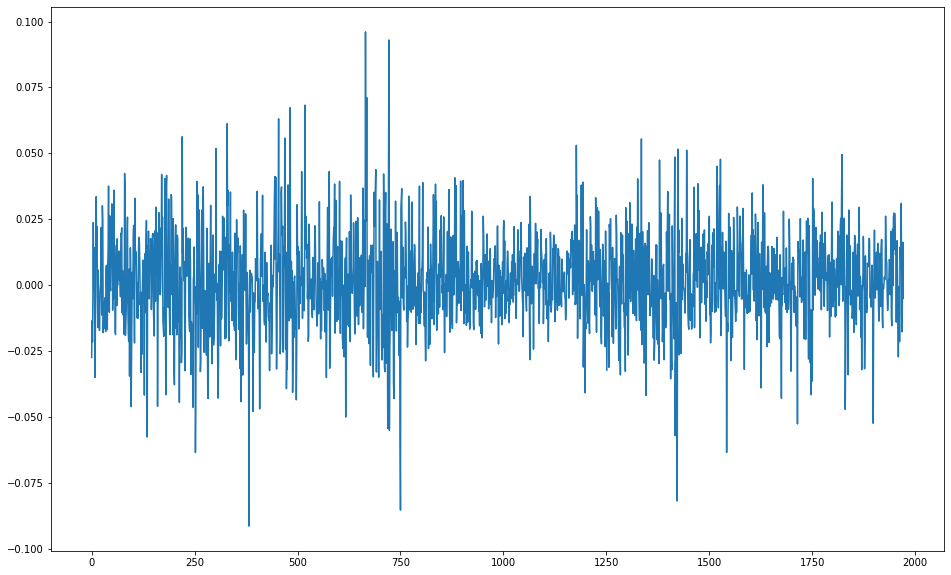

In [30]:
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);


- check the statistics of the signal

In [31]:
np.where(np.isnan(all_signal))

(array([], dtype=int64),)

In [32]:
print("kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))
## kurtosis= 6.432959352229932  skew= -0.07045980624895713

## we can see it has very fat tails
## usually we don't adjust for response because we want to profit from the fat tails

kurtosis= 5.265718107234023  skew= -0.04298896569026476


- let's try some vanish signal

kurtosis= 2.9741630636802916  skew= 0.07594832432285106


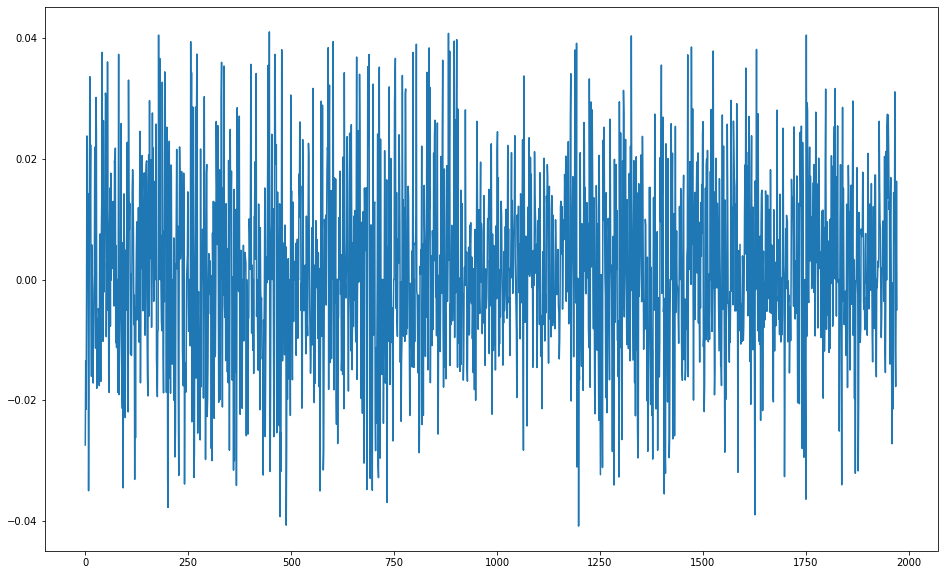

In [33]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
all_signal[np.isnan(all_signal)] = 0
vanish_signal = vanish_thre(all_signal, 0.041)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
## kurtosis= 2.8552698592700065  skew= 0.08567468891295049

plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);

kurtosis= 2.670391816063061  skew= 0.03520915484659102


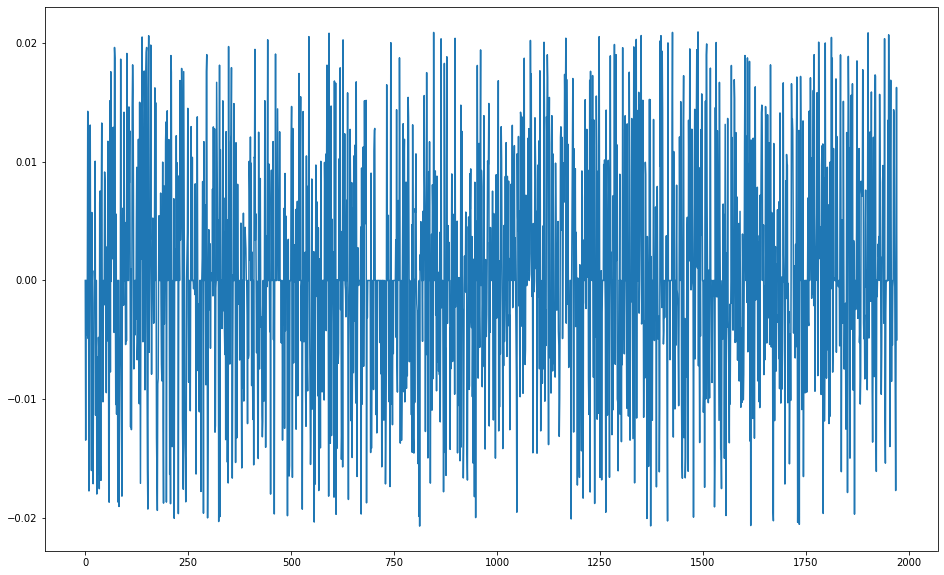

In [34]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
all_signal[np.isnan(all_signal)] = 0
vanish_signal = vanish_thre(all_signal, 0.021)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);
## kurtosis= 2.8768899798654184  skew= 0.0352689016906444






kurtosis= 3.6975554202361005  skew= 0.05885255641103574


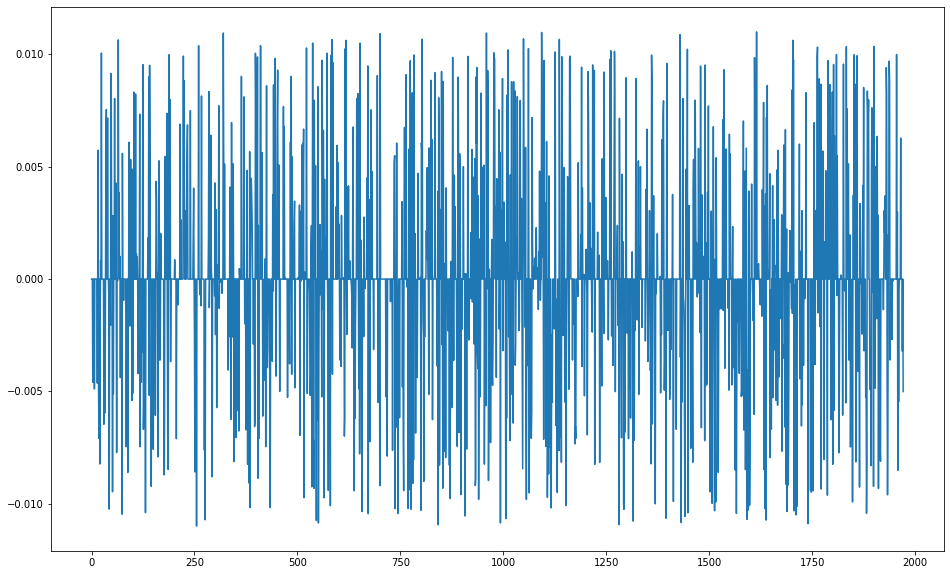

In [30]:
all_signal = load(SAVE_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
all_signal[np.isnan(all_signal)] = 0
vanish_signal = vanish_thre(all_signal, 0.011)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);
## kurtosis= 3.913273650595829  skew= -0.07067419539205458




- it seems 0.01 fits our previous standard for predictive signals
- but now we works for response so there may be some differences


- let's create signals with vanish as well
- our function can support only one parameter so we create twice

In [35]:
class foctor_ret_period_004(factor_template):
    factor_name = "ret.period.004"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.041).values
    
y4 = foctor_ret_period_004()



In [36]:
class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
    
y2 = foctor_ret_period_002()



In [37]:
for product in product_list:
    create_signal_path(y4, product, SAVE_PATH)

./ckpt//tmp pkl/600519/ret.4096.004
./ckpt//tmp pkl/000858/ret.4096.004
./ckpt//tmp pkl/000568/ret.4096.004
./ckpt//tmp pkl/600809/ret.4096.004
./ckpt//tmp pkl/002304/ret.4096.004


In [38]:
for product in product_list:
    create_signal_path(y2, product, SAVE_PATH)

./ckpt//tmp pkl/600519/ret.4096.002
./ckpt//tmp pkl/000858/ret.4096.002
./ckpt//tmp pkl/000568/ret.4096.002
./ckpt//tmp pkl/600809/ret.4096.002
./ckpt//tmp pkl/002304/ret.4096.002


In [39]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y4, product=product, HEAD_PATH=SAVE_PATH, n=8)
;
## Wall time: 1min 16s

CPU times: user 297 ms, sys: 249 ms, total: 546 ms
Wall time: 25.7 s


''

In [40]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y2, product=product, HEAD_PATH=SAVE_PATH,n=8)
;
## Wall time: 1min 13s

CPU times: user 306 ms, sys: 272 ms, total: 578 ms
Wall time: 26.1 s


''

In [41]:
class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
    
y1 = foctor_ret_period_001()


In [42]:
for product in product_list:
    create_signal_path(y1, product, SAVE_PATH)

./ckpt//tmp pkl/600519/ret.4096.001
./ckpt//tmp pkl/000858/ret.4096.001
./ckpt//tmp pkl/000568/ret.4096.001
./ckpt//tmp pkl/600809/ret.4096.001
./ckpt//tmp pkl/002304/ret.4096.001


In [43]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y1, product=product, HEAD_PATH=SAVE_PATH, n=8)
;
##Wall time: 1min 12s

CPU times: user 277 ms, sys: 238 ms, total: 515 ms
Wall time: 23.7 s


''

- now we have 3 response values: future return, future return cut off at 0.02, future return cut of at 0.01


- let's see how they perform with predictive signals


- at first we need to make sum changes 
- we can check the result

- at first we fit a linear regression model without any regularization
- we need to know the length of each day

# Stack all signal (X and Y)

## # of records

In [44]:
## coutn the number of signals of every day
def count_daily_num(x, period):
    data = load(x)
    return np.floor(np.shape(data)[0]/period)

In [45]:
os.makedirs(SAVE_PATH+"/daily num", exist_ok=True)

In [46]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, all_dates))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, SAVE_PATH+"/daily num/"+product+".pkl")
    
# Wall time: 39.6 s


CPU times: user 171 ms, sys: 230 ms, total: 401 ms
Wall time: 15.8 s


- we don't need to do it every time

In [47]:
daily_num = load(SAVE_PATH+"/daily num/"+product+".pkl")

In [48]:
daily_num

0      83.0
1     113.0
2     167.0
3     142.0
4     180.0
5     153.0
6     184.0
7     225.0
8     240.0
9     252.0
10     22.0
dtype: float64

- we get the number of independent training samples

- we can see there there are not many samples
- but they are independent signals because we choose one sample out of every period samples
- for every tick, we predict the price return of next 4096 ticks
- so only 1/4096 of them are independent

- number of signals

In [49]:
n_signal = len(signal_list)
n_signal
## 28

28

## Align all signals and stack over stocks

In [50]:
## construct the signal matrix
## we want to put multiple signals into a matrix
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample]) ## tottal number of samples
    n_signal = len(signal_list) ## number of signals, the matrix would be n_samples*n_signal
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    # file is the year - row
    for file in good_night_files[sample]:
        data = load(DATA_PATH+""+product+"/"+file)
        chosen = (np.arange(np.shape(data)[0])+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):   # signal per column
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

- Now we get the train and test samples

In [51]:
os.makedirs(SAVE_PATH+"/train test mat/", exist_ok=True)

In [52]:
train_sample = (all_dates<"2017")
test_sample = (all_dates>"2017")

In [53]:
%%time
for product in product_list:
    print(product)
    daily_num = load(SAVE_PATH+"/daily num/"+product+".pkl")
    train_mat = get_sample_signal(all_dates, train_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004" ]), 
                                  period, daily_num)
#     os.makedirs(SAVE_PATH+"/train test mat/"+product, exist_ok=True)
    save(train_mat, SAVE_PATH+"/train test mat/"+product+".train.mat.pkl")
    
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 3min 38s


600519
000858
000568
600809
002304
CPU times: user 1min 28s, sys: 6.63 s, total: 1min 35s
Wall time: 1min 37s


In [54]:
train_mat

,nr.4096,dbook.4096,range.pos.4096,price.osci.4096,ma.dif.10.4096,kdj.k.4096,kdj.j.4096,nr.range.4096,dbook.range.4096,range.pos.range.4096,...,dbook.trend.index.4096,range.pos.trend.index.4096,price.osci.trend.index.4096,ma.dif.10.trend.index.4096,kdj.k.trend.index.4096,kdj.j.trend.index.4096,ret.4096,ret.4096.001,ret.4096.002,ret.4096.004
0,-0.004399,-0.038782,-0.500000,0.000000,-0.014085,-1.000000,-1.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.117011,0.000000,0.000000,0.000000
1,-0.042325,0.052068,-0.406234,-0.456292,-0.071475,-0.783827,-0.805232,-1.509113,1.856499,-14.484256,...,0.036876,-0.287705,-0.323158,-0.050620,-0.555126,-0.570286,0.022412,0.000000,0.000000,0.022412
2,-0.009661,-0.021191,-0.224448,-0.223706,-0.019697,0.275059,-0.337160,-0.132370,-0.290365,-3.075418,...,-0.007131,-0.075526,-0.075276,-0.006628,0.092556,-0.113452,0.025900,0.000000,0.000000,0.025900
3,0.002977,-0.083371,0.036026,0.213174,0.010817,0.513283,0.431219,0.048332,-1.353452,0.584844,...,-0.028032,0.012113,0.071677,0.003637,0.172584,0.144991,-0.015946,0.000000,-0.015946,-0.015946
4,-0.003407,-0.042558,0.077616,-0.239982,-0.013899,-0.125209,0.301859,-0.055414,-0.692137,1.262301,...,-0.008838,0.016119,-0.049837,-0.002886,-0.026002,0.062687,-0.008779,-0.008779,-0.008779,-0.008779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,-0.004736,-0.122652,-0.017977,-0.207510,-0.005681,-0.293004,0.100053,-0.038281,-0.991480,-0.145322,...,-0.075078,-0.011004,-0.127021,-0.003478,-0.179354,0.061245,-0.014891,0.000000,-0.014891,-0.014891
834,-0.015859,-0.096020,-0.133418,-0.524005,-0.009020,-0.596722,-0.417779,-0.092314,-0.558912,-0.776598,...,-0.065718,-0.091314,-0.358639,-0.006173,-0.408408,-0.285936,-0.026868,0.000000,0.000000,-0.026868
835,-0.031898,-0.055870,-0.266329,-0.711711,-0.024284,-0.823868,-0.783059,-0.313847,-0.549715,-2.620442,...,-0.039975,-0.190555,-0.509222,-0.017375,-0.589469,-0.560270,0.025284,0.000000,0.000000,0.025284
836,0.004700,-0.081494,-0.051076,-0.030705,-0.003173,0.593226,0.169718,0.031417,-0.544736,-0.341409,...,-0.080703,-0.050580,-0.030407,-0.003142,0.587467,0.168070,0.014816,0.000000,0.014816,0.014816


In [55]:
ori_mat = load(SAVE_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
ori_mat.columns

Index(['nr.4096', 'dbook.4096', 'range.pos.4096', 'price.osci.4096',
       'ma.dif.10.4096', 'kdj.k.4096', 'kdj.j.4096', 'nr.range.4096',
       'dbook.range.4096', 'range.pos.range.4096', 'price.osci.range.4096',
       'ma.dif.10.range.4096', 'kdj.k.range.4096', 'kdj.j.range.4096',
       'nr.std.4096', 'dbook.std.4096', 'range.pos.std.4096',
       'price.osci.std.4096', 'ma.dif.10.std.4096', 'kdj.k.std.4096',
       'kdj.j.std.4096', 'nr.trend.index.4096', 'dbook.trend.index.4096',
       'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
       'ma.dif.10.trend.index.4096', 'kdj.k.trend.index.4096',
       'kdj.j.trend.index.4096', 'ret.4096', 'ret.4096.001', 'ret.4096.002',
       'ret.4096.004'],
      dtype='object')

- we add the y signal

- we can check the names

In [56]:
train_mat = load(SAVE_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=True), columns=ori_mat.columns)
print(product_list[0], train_mat.shape)
for product in product_list[1:]:
    cur_mat = load(SAVE_PATH+"/train test mat/"+product+".train.mat.pkl")
    # why??
    ## standardize the matrix before combination, with_mean=False,we don't use intercept
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=True), columns=ori_mat.columns)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)
    
# 600519 (1001, 32)
# 000858 (1281, 32)
# 000568 (1007, 32)
# 600809 (756, 32)
# 002304 (838, 32)



600519 (1001, 32)
000858 (1281, 32)
000568 (1007, 32)
600809 (756, 32)
002304 (838, 32)


In [57]:
train_mat

,nr.4096,dbook.4096,range.pos.4096,price.osci.4096,ma.dif.10.4096,kdj.k.4096,kdj.j.4096,nr.range.4096,dbook.range.4096,range.pos.range.4096,...,dbook.trend.index.4096,range.pos.trend.index.4096,price.osci.trend.index.4096,ma.dif.10.trend.index.4096,kdj.k.trend.index.4096,kdj.j.trend.index.4096,ret.4096,ret.4096.001,ret.4096.002,ret.4096.004
0,-0.649880,1.865378,-3.215220,-0.019421,-0.145744,-1.950298,-2.170202,-0.080910,-0.192300,-0.035399,...,-0.322644,0.017908,-0.037684,-0.059202,-0.001327,-0.004092,-1.248151,0.039214,0.054104,-1.622889
1,-1.653276,2.706105,-2.428178,-0.852449,-0.792771,-1.274815,-1.527584,-0.864832,1.531053,-1.511537,...,4.117243,-3.303669,-1.135354,-0.952396,-1.549685,-1.990131,-0.092656,-0.214160,-0.060430,-0.074334
2,-0.663453,1.649287,-1.855653,-1.051762,-0.591211,-0.800616,-0.951657,-0.258691,0.469564,-0.700442,...,-0.137144,-0.144888,-0.124190,-0.100562,-0.064161,-0.084045,-1.125045,0.039214,0.054104,-1.457906
3,-0.903487,1.884757,-1.965550,-0.873317,-1.206839,-0.874675,-1.416535,-0.600655,1.370034,-1.521962,...,1.978564,-1.894519,-0.832834,-1.042914,-0.761428,-1.308313,1.172068,0.039214,0.054104,1.620606
4,0.667105,0.929020,-0.641355,0.603106,0.318637,0.842289,0.058458,0.359863,0.750912,-0.578280,...,1.115922,-0.705269,0.590323,0.281966,0.728363,0.011914,0.055318,0.613882,0.313875,0.123975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,-0.241807,-2.466941,-0.023321,-0.380711,-0.163462,-0.551486,0.285736,-0.069796,-1.711738,-0.062499,...,-2.527208,-0.065204,-0.389168,-0.131086,-0.519792,0.255796,-0.400020,-0.033145,-1.733099,-0.851977
834,-0.848021,-2.018807,-0.791425,-1.008857,-0.280745,-1.171736,-0.885224,-0.145526,-1.079925,-0.371429,...,-2.253529,-0.956899,-1.128058,-0.252019,-1.222357,-1.002650,-0.717047,-0.033145,-0.013962,-1.532801
835,-1.722062,-1.343197,-1.675762,-1.381397,-0.816905,-1.635613,-1.711221,-0.456014,-1.066492,-1.273755,...,-1.500775,-2.058790,-1.608435,-0.754478,-1.777713,-1.997044,0.663382,-0.033145,-0.013962,1.431707
836,0.272409,-1.774370,-0.243546,-0.029807,-0.075364,1.258368,0.443266,0.027890,-1.059220,-0.158459,...,-2.691686,-0.504619,-0.080958,-0.116049,1.832234,0.643012,0.386296,-0.033145,1.696503,0.836656


In [58]:
train_mat.shape

# (4883, 32)

(4883, 32)

- at first we can fit a linear regression to calcualte t-statistics 

# Variable Y - 'ret.4096'

## Select variable X by t-stats

In [59]:
formula = "train_mat['ret."+str(period)+"'] ~ train_mat['nr."+str(period)+"'] + 0"
formula
## "train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

"train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

In [60]:
fit_one_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_one_lm.summary())

#                                   OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.000
# Model:                               OLS   Adj. R-squared (uncentered):             -0.000
# Method:                    Least Squares   F-statistic:                           0.003920
# Date:                   Thu, 15 Apr 2021   Prob (F-statistic):                       0.950
# Time:                           22:35:49   Log-Likelihood:                         -6928.7
# No. Observations:                   4883   AIC:                                  1.386e+04
# Df Residuals:                       4882   BIC:                                  1.387e+04
# Df Model:                              1                                                  
# Covariance Type:               nonrobust                                                  
# ========================================================================================
#                            coef    std err          t      P>|t|      [0.025      0.975]
# ----------------------------------------------------------------------------------------
# train_mat['nr.4096']     0.0009      0.014      0.063      0.950      -0.027       0.029
# ==============================================================================
# Omnibus:                      891.637   Durbin-Watson:                   1.962
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20551.831
# Skew:                           0.193   Prob(JB):                         0.00
# Kurtosis:                      13.043   Cond. No.                         1.00
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.



                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.000
Model:                               OLS   Adj. R-squared (uncentered):             -0.000
Method:                    Least Squares   F-statistic:                           0.003920
Date:                   Fri, 07 May 2021   Prob (F-statistic):                       0.950
Time:                           15:29:49   Log-Likelihood:                         -6928.7
No. Observations:                   4883   AIC:                                  1.386e+04
Df Residuals:                       4882   BIC:                                  1.387e+04
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-

In [61]:
## function to calculate t-stat
def get_t_value(train_mat, signal, response):
    beta = np.sum(train_mat[signal]*train_mat[response])/sum(train_mat[signal]**2) ## regressio coef
    sigma = np.sqrt(np.sum((train_mat[signal]*beta-train_mat[response])**2) / (len(train_mat)-1)) 
    v = np.sqrt(np.sum(train_mat[signal]**2)) ## sigma/v is the standard devication of beta_hat
    return beta/sigma*v

- we can see our function is correct
- now let's use this function to calcualte all t-stat of each variable

In [62]:
signal_list = np.array(signal_list)
t_stat = list(map(lambda x: get_t_value(train_mat=train_mat, signal=x, response="ret."+str(period)), signal_list))
t_stat

# [0.0626080522884078,
#  -2.645582926813177,
#  -0.5145178448224205,
#  -1.0064211360338151,
#  -1.7240987186492656,
#  1.355341456209274,
#  0.0043478114505952035,
#  -0.3083427819991165,
#  -4.004236071264482,
#  -1.9604491829336206,
#  -1.8134153607984276,
#  -0.39013523636439057,
#  0.334438510063254,
#  -1.0568419789902712,
#  -0.31564053752186716,
#  -4.50733796962979,
#  -1.4002350513209496,
#  -1.5389567383649174,
#  -0.3198416673440759,
#  0.6638006686212823,
#  -0.56506789845173,
#  0.8552731436925871,
#  -3.3025187255782305,
#  0.10142225291616137,
#  0.26486204193173946,
#  0.19614406002805893,
#  1.502017762930739,
#  0.6410178418066058]

[0.06260805228840804,
 -2.645582926813177,
 -0.5145178448224205,
 -1.0064211360338151,
 -1.7240987186492656,
 1.355341456209274,
 0.0043478114505952035,
 -0.308342781999116,
 -4.004236071264482,
 -1.9604491829336206,
 -1.8134153607984276,
 -0.39013523636439057,
 0.334438510063254,
 -1.0568419789902712,
 -0.3156405375218671,
 -4.50733796962979,
 -1.4002350513209496,
 -1.5389567383649174,
 -0.3198416673440759,
 0.6638006686212823,
 -0.56506789845173,
 0.8552731436925869,
 -3.3025187255782305,
 0.10142225291616137,
 0.26486204193173946,
 0.19614406002805893,
 1.502017762930739,
 0.6410178418066058]

- if we use t.stat value of 2 to filter out good signals, we have

In [63]:
signal_list[np.where(np.abs(t_stat)>1)]

# array(['dbook.4096', 'price.osci.4096', 'ma.dif.10.4096', 'kdj.k.4096',
#        'dbook.range.4096', 'range.pos.range.4096',
#        'price.osci.range.4096', 'kdj.j.range.4096', 'dbook.std.4096',
#        'range.pos.std.4096', 'price.osci.std.4096',
#        'dbook.trend.index.4096', 'kdj.k.trend.index.4096'], dtype='<U27')

array(['dbook.4096', 'price.osci.4096', 'ma.dif.10.4096', 'kdj.k.4096',
       'dbook.range.4096', 'range.pos.range.4096',
       'price.osci.range.4096', 'kdj.j.range.4096', 'dbook.std.4096',
       'range.pos.std.4096', 'price.osci.std.4096',
       'dbook.trend.index.4096', 'kdj.k.trend.index.4096'], dtype='<U27')

- but we know a single signal works well doesn't mean it works well when combined with other signals
- signals have correlation, if 10 highly correlated signals together would not make prediction better

In [64]:
good_index = np.where(np.abs(t_stat)>1)
train_mat.iloc[good_index].corr()



,nr.4096,dbook.4096,range.pos.4096,price.osci.4096,ma.dif.10.4096,kdj.k.4096,kdj.j.4096,nr.range.4096,dbook.range.4096,range.pos.range.4096,...,dbook.trend.index.4096,range.pos.trend.index.4096,price.osci.trend.index.4096,ma.dif.10.trend.index.4096,kdj.k.trend.index.4096,kdj.j.trend.index.4096,ret.4096,ret.4096.001,ret.4096.002,ret.4096.004
nr.4096,1.000000,-0.663883,0.886401,0.868596,0.870933,0.847624,0.853324,0.957577,-0.734574,0.871828,...,-0.743703,0.863427,0.912468,0.814137,0.816620,0.886038,-0.094962,0.415748,0.164097,-0.075606
dbook.4096,-0.663883,1.000000,-0.800471,-0.400053,-0.493849,-0.306191,-0.423913,-0.649406,0.946975,-0.778257,...,0.916981,-0.829250,-0.547463,-0.492919,-0.350026,-0.546466,0.001688,-0.525462,-0.298291,-0.164191
range.pos.4096,0.886401,-0.800471,1.000000,0.763795,0.789031,0.641180,0.826370,0.840846,-0.878491,0.950636,...,-0.852869,0.900026,0.738759,0.693575,0.569291,0.756677,-0.247286,0.322041,0.144700,-0.160264
price.osci.4096,0.868596,-0.400053,0.763795,1.000000,0.907812,0.806720,0.811556,0.819264,-0.504035,0.729201,...,-0.445548,0.584673,0.778950,0.705803,0.646623,0.673353,-0.155393,0.317248,0.047837,-0.288517
ma.dif.10.4096,0.870933,-0.493849,0.789031,0.907812,1.000000,0.842256,0.857149,0.931928,-0.647442,0.865909,...,-0.506516,0.690994,0.890251,0.912210,0.748718,0.812584,-0.083442,0.465505,0.214687,-0.157891
kdj.k.4096,0.847624,-0.306191,0.641180,0.806720,0.842256,1.000000,0.898484,0.862436,-0.476564,0.698944,...,-0.407781,0.614743,0.860456,0.791696,0.905158,0.847206,0.055013,0.258819,0.033742,-0.125867
kdj.j.4096,0.853324,-0.423913,0.826370,0.811556,0.857149,0.898484,1.000000,0.856078,-0.600790,0.834525,...,-0.544413,0.724750,0.822838,0.788263,0.765128,0.830706,-0.155289,0.114812,-0.030027,-0.240705
nr.range.4096,0.957577,-0.649406,0.840846,0.819264,0.931928,0.862436,0.856078,1.000000,-0.752789,0.903958,...,-0.688793,0.844358,0.961477,0.929030,0.857709,0.922960,-0.031519,0.517778,0.283623,0.001384
dbook.range.4096,-0.734574,0.946975,-0.878491,-0.504035,-0.647442,-0.476564,-0.600790,-0.752789,1.000000,-0.910448,...,0.917532,-0.899782,-0.651825,-0.644935,-0.490622,-0.692975,0.026487,-0.530052,-0.304504,-0.068921
range.pos.range.4096,0.871828,-0.778257,0.950636,0.729201,0.865909,0.698944,0.834525,0.903958,-0.910448,1.000000,...,-0.820354,0.918757,0.826790,0.843403,0.675693,0.853937,-0.166227,0.452862,0.239942,-0.094151


## Check correlation amongs X by t-stats

In [65]:
corr = train_mat.iloc[good_index].corr()

In [66]:
%pip install seaborn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


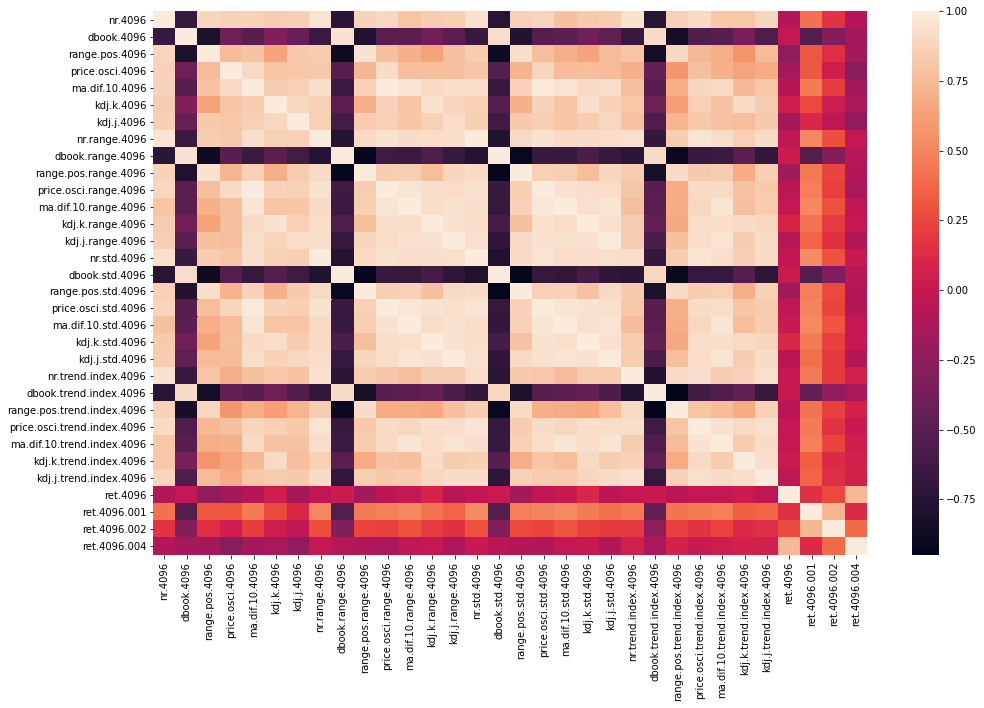

In [67]:
import seaborn as sns
plt.figure(figsize=(16,10)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

- we can see that some of them has very high correlation

- we can add each signal one by one to a model and check how the performance envolves

In [68]:
np.argmax(np.abs(t_stat))
## [1] 15

15

In [69]:
signal_list[np.argmax(np.abs(t_stat))]
## 'dbook.std.4096'

'dbook.std.4096'

- the first signal is the signal dbook.std.4096


- to select the second signal, we can use forward selction

## Select variable X by forward selection

In [70]:
import statsmodels.formula.api as smf

## forward selection of signals
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    chosen_signals = []
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} - 1".format("data['"+response+"']",
                                           ' + '.join(selected + ["data['"+candidate+"']"]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append("data['"+best_candidate+"']")
            current_score = best_new_score
            chosen_signals.append(best_candidate)
    formula = "{} ~ {} - 1".format("data['"+response+"']",
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return OrderedDict([("model", model), ("chosen.signals", chosen_signals)])

In [71]:
train_mat.columns[:-3]

Index(['nr.4096', 'dbook.4096', 'range.pos.4096', 'price.osci.4096',
       'ma.dif.10.4096', 'kdj.k.4096', 'kdj.j.4096', 'nr.range.4096',
       'dbook.range.4096', 'range.pos.range.4096', 'price.osci.range.4096',
       'ma.dif.10.range.4096', 'kdj.k.range.4096', 'kdj.j.range.4096',
       'nr.std.4096', 'dbook.std.4096', 'range.pos.std.4096',
       'price.osci.std.4096', 'ma.dif.10.std.4096', 'kdj.k.std.4096',
       'kdj.j.std.4096', 'nr.trend.index.4096', 'dbook.trend.index.4096',
       'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
       'ma.dif.10.trend.index.4096', 'kdj.k.trend.index.4096',
       'kdj.j.trend.index.4096', 'ret.4096'],
      dtype='object')

In [72]:
result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))

In [73]:
save(result, SAVE_PATH+"/medical_all_forwatd_select.pkl")

In [74]:
result = load(SAVE_PATH+"/medical_all_forwatd_select.pkl");

In [75]:
result["model"].model.formula
# "data['ret.4096'] ~ data['dbook.std.4096'] + data['range.pos.range.4096'] + data['kdj.k.std.4096'] + data['price.osci.std.4096'] + data['ma.dif.10.trend.index.4096'] + data['ma.dif.10.range.4096'] + data['range.pos.trend.index.4096'] + data['ma.dif.10.4096'] + data['price.osci.4096'] + data['range.pos.4096'] + data['range.pos.std.4096'] + data['kdj.j.range.4096'] + data['kdj.j.std.4096'] + data['ma.dif.10.std.4096'] + data['price.osci.range.4096'] + data['nr.4096'] + data['nr.range.4096'] + data['dbook.4096'] - 1"


"data['ret.4096'] ~ data['dbook.std.4096'] + data['range.pos.range.4096'] + data['kdj.k.std.4096'] + data['price.osci.std.4096'] + data['ma.dif.10.trend.index.4096'] + data['ma.dif.10.range.4096'] + data['range.pos.trend.index.4096'] + data['ma.dif.10.4096'] + data['price.osci.4096'] + data['range.pos.4096'] + data['range.pos.std.4096'] + data['kdj.j.range.4096'] + data['kdj.j.std.4096'] + data['ma.dif.10.std.4096'] + data['price.osci.range.4096'] + data['nr.4096'] + data['nr.range.4096'] + data['dbook.4096'] - 1"

In [76]:
result["chosen.signals"]

# ['dbook.std.4096',
#  'range.pos.range.4096',
#  'kdj.k.std.4096',
#  'price.osci.std.4096',
#  'ma.dif.10.trend.index.4096',
#  'ma.dif.10.range.4096',
#  'range.pos.trend.index.4096',
#  'ma.dif.10.4096',
#  'price.osci.4096',
#  'range.pos.4096',
#  'range.pos.std.4096',
#  'kdj.j.range.4096',
#  'kdj.j.std.4096',
#  'ma.dif.10.std.4096',
#  'price.osci.range.4096',
#  'nr.4096',
#  'nr.range.4096',
#  'dbook.4096']

['dbook.std.4096',
 'range.pos.range.4096',
 'kdj.k.std.4096',
 'price.osci.std.4096',
 'ma.dif.10.trend.index.4096',
 'ma.dif.10.range.4096',
 'range.pos.trend.index.4096',
 'ma.dif.10.4096',
 'price.osci.4096',
 'range.pos.4096',
 'range.pos.std.4096',
 'kdj.j.range.4096',
 'kdj.j.std.4096',
 'ma.dif.10.std.4096',
 'price.osci.range.4096',
 'nr.4096',
 'nr.range.4096',
 'dbook.4096']

- now we can check each model to see how the pnl evolves


- we can also get the test signals


- we can get the test samples first

In [77]:
%%time
for product in product_list:
    print(product)
    daily_num = load(SAVE_PATH+"/daily num/"+product+".pkl")
    test_mat = get_sample_signal(all_dates, test_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004"]), 
                                  period, daily_num)
#     os.makedirs(SAVE_PATH+"/train test mat/"+product, exist_ok=True)
    save(test_mat, SAVE_PATH+"/train test mat/"+product+".test.mat.pkl")
    
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 3min 46s



600519
000858
000568
600809
002304
CPU times: user 1min 29s, sys: 7.26 s, total: 1min 37s
Wall time: 1min 38s


- now let's fit the first model

## OLS with 1st variables

In [78]:
first_signal = 'dbook.std.'+str(period)
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ train_mat['"+first_signal+"']+0"
formula

# "train_mat['ret.4096'] ~ train_mat['dbook.std.4096']+0"

"train_mat['ret.4096'] ~ train_mat['dbook.std.4096']+0"

In [79]:
fit1_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit1_lm.summary())

#  OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.004
# Model:                               OLS   Adj. R-squared (uncentered):              0.004
# Method:                    Least Squares   F-statistic:                              20.32
# Date:                   Thu, 15 Apr 2021   Prob (F-statistic):                    6.72e-06
# Time:                           22:47:07   Log-Likelihood:                         -6918.5
# No. Observations:                   4883   AIC:                                  1.384e+04
# Df Residuals:                       4882   BIC:                                  1.385e+04
# Df Model:                              1                                                  
# Covariance Type:               nonrobust                                                  
# ===============================================================================================
#                                   coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------
# train_mat['dbook.std.4096']    -0.0644      0.014     -4.507      0.000      -0.092      -0.036
# ==============================================================================
# Omnibus:                      883.458   Durbin-Watson:                   1.996
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20097.598
# Skew:                           0.184   Prob(JB):                         0.00
# Kurtosis:                      12.932   Cond. No.                         1.00
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.004
Model:                               OLS   Adj. R-squared (uncentered):              0.004
Method:                    Least Squares   F-statistic:                              20.32
Date:                   Fri, 07 May 2021   Prob (F-statistic):                    6.72e-06
Time:                           15:31:36   Log-Likelihood:                         -6918.5
No. Observations:                   4883   AIC:                                  1.384e+04
Df Residuals:                       4882   BIC:                                  1.385e+04
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0

- we can see that the single R-square is already 0.001

- now we want to get the prediction value

In [80]:
strat = "one."+str(period)

- create a directory for the first strate

In [81]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

- we get the coefficiton of fit1.lm

In [82]:
fit_coef = fit1_lm.params.values
fit_coef
# array([-0.06437533])

array([-0.06437533])

- but since we have standardize the training samples before regrssion
- we must revert the result to original scale

## Predication by 1st variable OLS

In [83]:
train_std = dict([])
for product in product_list:
    cur_mat = load(SAVE_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std[product] = np.std(cur_mat)

In [84]:
%%time
for product in product_list:
    # Y/std(Y) ~ fit_coef*x/std(x) => Y ~ fit_coef*std(Y)/std(x)*x
    coef = fit_coef*train_std[product][y_signal]/train_std[product][first_signal]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=[first_signal], coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)


## Wall time: 57.3 s

CPU times: user 180 ms, sys: 256 ms, total: 436 ms
Wall time: 15.5 s


In [85]:
first_signal

'dbook.std.4096'

In [86]:
%%time
for product in product_list:
    par_get_all_signal("one.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)
## Wall time: 5.26 s

CPU times: user 2.4 s, sys: 318 ms, total: 2.72 s
Wall time: 2.94 s


In [89]:
%%time
for product in product_list:
    evaluate_signal("one", all_dates, product, 0.001, 20, CORE_NUM, SAVE_PATH, SAVE_PATH,
                        period=4096, split_str="2017",atr_filter=0.02, save_path="signal result atr", reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 23min 32s


reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
CPU times: user 546 ms, sys: 495 ms, total: 1.04 s
Wall time: 8min 24s


In [90]:
for product in product_list:
    signal_stat = load(SAVE_PATH+"/signal result atr/"+product+"."+"one.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# 600519 train sharpe  0.27063629544453416 test sharpe  -0.575433979949332
# 000858 train sharpe  0.08284281993855752 test sharpe  -0.7329246846083604
# 000568 train sharpe  0.13495257369201996 test sharpe  -0.044726066855284664
# 600809 train sharpe  0.5434354365418662 test sharpe  -0.17314788261875227
# 002304 train sharpe  0.25295423783020754 test sharpe  0.5559140629198502






600519 train sharpe  0.21422844421613568 test sharpe  -0.6093312555668321
000858 train sharpe  0.08076516690803003 test sharpe  -0.6894893617269536
000568 train sharpe  0.3023554327529001 test sharpe  -0.26111587863608593
600809 train sharpe  0.5440351667639102 test sharpe  -0.271980976633191
002304 train sharpe  0.3932770163592402 test sharpe  0.0075348712311173105


- then we work similar to previous common signals

- now we try to add a few new signal

## Predication by half selected X

In [91]:
train_mat

,nr.4096,dbook.4096,range.pos.4096,price.osci.4096,ma.dif.10.4096,kdj.k.4096,kdj.j.4096,nr.range.4096,dbook.range.4096,range.pos.range.4096,...,dbook.trend.index.4096,range.pos.trend.index.4096,price.osci.trend.index.4096,ma.dif.10.trend.index.4096,kdj.k.trend.index.4096,kdj.j.trend.index.4096,ret.4096,ret.4096.001,ret.4096.002,ret.4096.004
0,-0.649880,1.865378,-3.215220,-0.019421,-0.145744,-1.950298,-2.170202,-0.080910,-0.192300,-0.035399,...,-0.322644,0.017908,-0.037684,-0.059202,-0.001327,-0.004092,-1.248151,0.039214,0.054104,-1.622889
1,-1.653276,2.706105,-2.428178,-0.852449,-0.792771,-1.274815,-1.527584,-0.864832,1.531053,-1.511537,...,4.117243,-3.303669,-1.135354,-0.952396,-1.549685,-1.990131,-0.092656,-0.214160,-0.060430,-0.074334
2,-0.663453,1.649287,-1.855653,-1.051762,-0.591211,-0.800616,-0.951657,-0.258691,0.469564,-0.700442,...,-0.137144,-0.144888,-0.124190,-0.100562,-0.064161,-0.084045,-1.125045,0.039214,0.054104,-1.457906
3,-0.903487,1.884757,-1.965550,-0.873317,-1.206839,-0.874675,-1.416535,-0.600655,1.370034,-1.521962,...,1.978564,-1.894519,-0.832834,-1.042914,-0.761428,-1.308313,1.172068,0.039214,0.054104,1.620606
4,0.667105,0.929020,-0.641355,0.603106,0.318637,0.842289,0.058458,0.359863,0.750912,-0.578280,...,1.115922,-0.705269,0.590323,0.281966,0.728363,0.011914,0.055318,0.613882,0.313875,0.123975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,-0.241807,-2.466941,-0.023321,-0.380711,-0.163462,-0.551486,0.285736,-0.069796,-1.711738,-0.062499,...,-2.527208,-0.065204,-0.389168,-0.131086,-0.519792,0.255796,-0.400020,-0.033145,-1.733099,-0.851977
834,-0.848021,-2.018807,-0.791425,-1.008857,-0.280745,-1.171736,-0.885224,-0.145526,-1.079925,-0.371429,...,-2.253529,-0.956899,-1.128058,-0.252019,-1.222357,-1.002650,-0.717047,-0.033145,-0.013962,-1.532801
835,-1.722062,-1.343197,-1.675762,-1.381397,-0.816905,-1.635613,-1.711221,-0.456014,-1.066492,-1.273755,...,-1.500775,-2.058790,-1.608435,-0.754478,-1.777713,-1.997044,0.663382,-0.033145,-0.013962,1.431707
836,0.272409,-1.774370,-0.243546,-0.029807,-0.075364,1.258368,0.443266,0.027890,-1.059220,-0.158459,...,-2.691686,-0.504619,-0.080958,-0.116049,1.832234,0.643012,0.386296,-0.033145,1.696503,0.836656


In [92]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
n_signal = int(len(result["chosen.signals"])/2)
for signal in result["chosen.signals"][:n_signal]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
# "train_mat['ret.4096'] ~ +train_mat['dbook.std.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.trend.index.4096']+train_mat['ma.dif.10.4096']+train_mat['price.osci.4096']+0"

"train_mat['ret.4096'] ~ +train_mat['dbook.std.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.trend.index.4096']+train_mat['ma.dif.10.4096']+train_mat['price.osci.4096']+0"

In [93]:
fit_half_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit_half_lm.summary())

#    OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.017
# Model:                               OLS   Adj. R-squared (uncentered):              0.006
# Method:                    Least Squares   F-statistic:                              1.598
# Date:                   Fri, 16 Apr 2021   Prob (F-statistic):                       0.112
# Time:                           23:34:58   Log-Likelihood:                          1563.4
# No. Observations:                    838   AIC:                                     -3109.
# Df Residuals:                        829   BIC:                                     -3066.
# Df Model:                              9                                                  
# Covariance Type:               nonrobust                                                  
# ===========================================================================================================
#                                               coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------
# train_mat['dbook.std.4096']                -0.0153      0.007     -2.178      0.030      -0.029      -0.002
# train_mat['range.pos.range.4096']          -0.0028      0.002     -1.359      0.174      -0.007       0.001
# train_mat['kdj.k.std.4096']                 0.0010      0.002      0.649      0.517      -0.002       0.004
# train_mat['price.osci.std.4096']           -0.0039      0.004     -1.114      0.266      -0.011       0.003
# train_mat['ma.dif.10.trend.index.4096']    -0.2875      0.311     -0.924      0.356      -0.898       0.323
# train_mat['ma.dif.10.range.4096']           0.0093      0.003      3.022      0.003       0.003       0.015
# train_mat['range.pos.trend.index.4096']     0.0424      0.042      1.004      0.316      -0.041       0.125
# train_mat['ma.dif.10.4096']                 0.0665      0.247      0.270      0.787      -0.418       0.551
# train_mat['price.osci.4096']                0.0063      0.008      0.783      0.434      -0.009       0.022
# ==============================================================================
# Omnibus:                      449.509   Durbin-Watson:                   1.992
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66937.990
# Skew:                           1.368   Prob(JB):                         0.00
# Kurtosis:                      46.699   Cond. No.                     1.14e+03
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
# [2] The condition number is large, 1.14e+03. This might indicate that there are
# strong multicollinearity or other numerical problems.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.020
Model:                               OLS   Adj. R-squared (uncentered):              0.018
Method:                    Least Squares   F-statistic:                              11.09
Date:                   Fri, 07 May 2021   Prob (F-statistic):                    2.62e-17
Time:                           15:51:58   Log-Likelihood:                         -6879.2
No. Observations:                   4883   AIC:                                  1.378e+04
Df Residuals:                       4874   BIC:                                  1.383e+04
Df Model:                              9                                                  
Covariance Type:               nonrobust                                                  
                                              coef    std err          t      P>|t|      [

In [94]:
strat = "half."+str(period)
fit_coef = fit_half_lm.params.values
fit_coef

# array([-0.01528798, -0.00279151,  0.00100813, -0.00389931, -0.2875167 ,
#         0.00934777,  0.04238709,  0.06653391,  0.00626646])

array([-0.09957469, -0.09448171,  0.09867341, -0.2312246 ,  0.17173736,
        0.20903682,  0.01194223, -0.33774026,  0.18601942])

In [95]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [96]:
%%time
for product in product_list:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][result["chosen.signals"][:n_signal]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:n_signal], coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

CPU times: user 218 ms, sys: 270 ms, total: 488 ms
Wall time: 24.5 s


''

In [97]:
%%time
for product in product_list:
    par_get_all_signal("half.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)
## Wall time: 5.15 s

CPU times: user 2.37 s, sys: 321 ms, total: 2.69 s
Wall time: 2.87 s


In [98]:
%%time
for product in product_list:
    evaluate_signal("half", all_dates, product, 0.001, 20, CORE_NUM, SAVE_PATH, SAVE_PATH,
                        period=4096, split_str="2017",atr_filter=0.02, save_path="signal result atr", reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 23min 24s


reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
CPU times: user 598 ms, sys: 548 ms, total: 1.15 s
Wall time: 10min 2s


In [99]:
for product in product_list:
    signal_stat = load(SAVE_PATH+"/signal result atr/"+product+"."+"half.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    
# 600519 train sharpe  0.6646261954987951 test sharpe  1.1135521930626697
# 000858 train sharpe  0.527924785915753 test sharpe  1.1048992460597913
# 000568 train sharpe  1.0778581733878967 test sharpe  -0.47832578264116343
# 600809 train sharpe  0.2288829415279083 test sharpe  0.3469180964187829
# 002304 train sharpe  0.16231286940445558 test sharpe  -0.3088404061880135

600519 train sharpe  0.06247409825958505 test sharpe  -0.4690816913271269
000858 train sharpe  0.46505651626992534 test sharpe  -0.4560877631073705
000568 train sharpe  0.6384190645946246 test sharpe  -0.7385231328329426
600809 train sharpe  nan test sharpe  nan
002304 train sharpe  0.6641591608030429 test sharpe  -0.2721357880871797


- now we look at the full model

## Predication by all selected X

In [100]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

# "train_mat['ret.4096'] ~ +train_mat['dbook.std.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.trend.index.4096']+train_mat['ma.dif.10.4096']+train_mat['price.osci.4096']+train_mat['range.pos.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.std.4096']+train_mat['ma.dif.10.std.4096']+train_mat['price.osci.range.4096']+train_mat['nr.4096']+train_mat['nr.range.4096']+train_mat['dbook.4096']+0"

"train_mat['ret.4096'] ~ +train_mat['dbook.std.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.trend.index.4096']+train_mat['ma.dif.10.4096']+train_mat['price.osci.4096']+train_mat['range.pos.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.std.4096']+train_mat['ma.dif.10.std.4096']+train_mat['price.osci.range.4096']+train_mat['nr.4096']+train_mat['nr.range.4096']+train_mat['dbook.4096']+0"

In [101]:
fit_full_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
print(fit_full_lm.summary())

#  OLS Regression Results                                  
# ==========================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.026
# Model:                               OLS   Adj. R-squared (uncentered):              0.022
# Method:                    Least Squares   F-statistic:                              7.187
# Date:                   Thu, 15 Apr 2021   Prob (F-statistic):                    1.34e-18
# Time:                           23:13:59   Log-Likelihood:                         -6864.6
# No. Observations:                   4883   AIC:                                  1.377e+04
# Df Residuals:                       4865   BIC:                                  1.388e+04
# Df Model:                             18                                                  
# Covariance Type:               nonrobust                                                  
# ===========================================================================================================
#                                               coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------
# train_mat['dbook.std.4096']                -0.1268      0.023     -5.465      0.000      -0.172      -0.081
# train_mat['range.pos.range.4096']           0.3605      0.146      2.467      0.014       0.074       0.647
# train_mat['kdj.k.std.4096']                 0.1411      0.056      2.509      0.012       0.031       0.251
# train_mat['price.osci.std.4096']            0.0628      0.140      0.448      0.654      -0.212       0.338
# train_mat['ma.dif.10.trend.index.4096']     0.2145      0.071      3.032      0.002       0.076       0.353
# train_mat['ma.dif.10.range.4096']           0.7064      0.149      4.740      0.000       0.414       0.999
# train_mat['range.pos.trend.index.4096']    -0.0725      0.055     -1.320      0.187      -0.180       0.035
# train_mat['ma.dif.10.4096']                -0.4596      0.089     -5.161      0.000      -0.634      -0.285
# train_mat['price.osci.4096']                0.1276      0.056      2.294      0.022       0.019       0.237
# train_mat['range.pos.4096']                 0.1531      0.054      2.812      0.005       0.046       0.260
# train_mat['range.pos.std.4096']            -0.5147      0.151     -3.406      0.001      -0.811      -0.218
# train_mat['kdj.j.range.4096']              -0.5716      0.186     -3.079      0.002      -0.936      -0.208
# train_mat['kdj.j.std.4096']                 0.5437      0.207      2.623      0.009       0.137       0.950
# train_mat['ma.dif.10.std.4096']            -0.4415      0.135     -3.269      0.001      -0.706      -0.177
# train_mat['price.osci.range.4096']         -0.2756      0.139     -1.980      0.048      -0.549      -0.003
# train_mat['nr.4096']                        0.1233      0.052      2.392      0.017       0.022       0.224
# train_mat['nr.range.4096']                 -0.0878      0.053     -1.652      0.099      -0.192       0.016
# train_mat['dbook.4096']                     0.0333      0.024      1.390      0.165      -0.014       0.080
# ==============================================================================
# Omnibus:                      884.133   Durbin-Watson:                   1.994
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20829.058
# Skew:                           0.154   Prob(JB):                         0.00
# Kurtosis:                      13.113   Cond. No.                         86.6
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                                  OLS Regression Results                                  
Dep. Variable:     train_mat['ret.4096']   R-squared (uncentered):                   0.026
Model:                               OLS   Adj. R-squared (uncentered):              0.022
Method:                    Least Squares   F-statistic:                              7.187
Date:                   Fri, 07 May 2021   Prob (F-statistic):                    1.34e-18
Time:                           16:02:28   Log-Likelihood:                         -6864.6
No. Observations:                   4883   AIC:                                  1.377e+04
Df Residuals:                       4865   BIC:                                  1.388e+04
Df Model:                             18                                                  
Covariance Type:               nonrobust                                                  
                                              coef    std err          t      P>|t|      [

In [102]:
strat = "full."+str(period)
os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_full_lm.params.values
fit_coef

# array([-0.1268128 ,  0.36054149,  0.14106894,  0.06284151,  0.21451209,
#         0.70638957, -0.07251718, -0.45959168,  0.12760555,  0.1531396 ,
#        -0.51471951, -0.57164471,  0.54372765, -0.44151381, -0.27564749,
#         0.12326802, -0.08781666,  0.03332524])

array([-0.1268128 ,  0.36054149,  0.14106894,  0.06284151,  0.21451209,
        0.70638957, -0.07251718, -0.45959168,  0.12760555,  0.1531396 ,
       -0.51471951, -0.57164471,  0.54372765, -0.44151381, -0.27564749,
        0.12326802, -0.08781666,  0.03332524])

In [103]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [104]:
coef

dbook.std.4096               -0.017175
range.pos.range.4096         -0.001747
kdj.k.std.4096                0.001502
price.osci.std.4096          -0.004012
ma.dif.10.trend.index.4096    0.291039
ma.dif.10.range.4096          0.005453
range.pos.trend.index.4096    0.005009
ma.dif.10.4096               -0.448198
price.osci.4096               0.013948
dtype: float64

In [105]:
result["chosen.signals"]

['dbook.std.4096',
 'range.pos.range.4096',
 'kdj.k.std.4096',
 'price.osci.std.4096',
 'ma.dif.10.trend.index.4096',
 'ma.dif.10.range.4096',
 'range.pos.trend.index.4096',
 'ma.dif.10.4096',
 'price.osci.4096',
 'range.pos.4096',
 'range.pos.std.4096',
 'kdj.j.range.4096',
 'kdj.j.std.4096',
 'ma.dif.10.std.4096',
 'price.osci.range.4096',
 'nr.4096',
 'nr.range.4096',
 'dbook.4096']

In [106]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std[product][y_signal]/train_std[product][result["chosen.signals"]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], coef=coef, strat="full.4096", HEAD_PATH=SAVE_PATH)
    
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 1min 18s




600519
000858
000568
600809
002304
CPU times: user 223 ms, sys: 257 ms, total: 480 ms
Wall time: 38.9 s


In [107]:
%%time
for product in product_list:
    par_get_all_signal("full.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)
## Wall time: 5.21 s

CPU times: user 2.45 s, sys: 363 ms, total: 2.81 s
Wall time: 3.01 s


In [108]:
%%time
for product in product_list:
    evaluate_signal("full", all_dates, product, 0.001, 20, CORE_NUM, SAVE_PATH, SAVE_PATH,
                        period=4096, split_str="2017",atr_filter=0.02, save_path="signal result atr", reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 23min 26s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
CPU times: user 601 ms, sys: 543 ms, total: 1.14 s
Wall time: 10min 48s


In [109]:
for product in product_list:
    signal_stat = load(SAVE_PATH+"/signal result atr/"+product+"."+"full.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# 600519 train sharpe  nan test sharpe  nan
# 000858 train sharpe  0.46852981123657195 test sharpe  -0.7778655789170691
# 000568 train sharpe  nan test sharpe  nan
# 600809 train sharpe  nan test sharpe  nan
# 002304 train sharpe  0.12706892539529063 test sharpe  -0.04094184017617699




600519 train sharpe  nan test sharpe  nan
000858 train sharpe  0.46425828601361957 test sharpe  -0.7770140880491502
000568 train sharpe  0.21350472632004303 test sharpe  -0.8701168055203254
600809 train sharpe  nan test sharpe  nan
002304 train sharpe  0.13657699269137358 test sharpe  -0.12229344317103161


# Variable Y - 'ret.4096.004'

In [110]:
y_signal = "ret."+str(period)+".004"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

## "train_mat['ret.4096.004'] ~ +train_mat['dbook.std.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.trend.index.4096']+train_mat['ma.dif.10.4096']+train_mat['price.osci.4096']+train_mat['range.pos.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.std.4096']+train_mat['ma.dif.10.std.4096']+train_mat['price.osci.range.4096']+train_mat['nr.4096']+train_mat['nr.range.4096']+train_mat['dbook.4096']+0"

"train_mat['ret.4096.004'] ~ +train_mat['dbook.std.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.trend.index.4096']+train_mat['ma.dif.10.4096']+train_mat['price.osci.4096']+train_mat['range.pos.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.std.4096']+train_mat['ma.dif.10.std.4096']+train_mat['price.osci.range.4096']+train_mat['nr.4096']+train_mat['nr.range.4096']+train_mat['dbook.4096']+0"

In [111]:
fit_004_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
strat = "full.004."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_004_lm.params.values
fit_coef

# array([-0.06111751,  0.13224739,  0.16685309, -0.03852343,  0.09664436,
#         0.19118682, -0.04107449, -0.29680494,  0.08025755,  0.08570274,
#        -0.09934285, -0.12821429, -0.03442788, -0.07522117, -0.1325847 ,
#         0.0704026 ,  0.00830644,  0.01613299])

array([-0.06111751,  0.13224739,  0.16685309, -0.03852343,  0.09664436,
        0.19118682, -0.04107449, -0.29680494,  0.08025755,  0.08570274,
       -0.09934285, -0.12821429, -0.03442788, -0.07522117, -0.1325847 ,
        0.0704026 ,  0.00830644,  0.01613299])

In [112]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std[product][y_signal]/train_std[product][result["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
    
# 600519
# dbook.std.4096               -0.005243
# range.pos.range.4096          0.001393
# kdj.k.std.4096                0.001861
# price.osci.std.4096          -0.000525
# ma.dif.10.trend.index.4096    0.149114
# ma.dif.10.range.4096          0.010667
# range.pos.trend.index.4096   -0.007692
# ma.dif.10.4096               -0.302042
# price.osci.4096               0.002835
# range.pos.4096                0.009586
# range.pos.std.4096           -0.003994
# kdj.j.range.4096             -0.000426
# kdj.j.std.4096               -0.000445
# ma.dif.10.std.4096           -0.015752
# price.osci.range.4096        -0.000464
# nr.4096                       0.066151
# nr.range.4096                 0.000603
# dbook.4096                    0.003933
# dtype: float64
# 000858
# dbook.std.4096               -0.040895
# range.pos.range.4096          0.013472
# kdj.k.std.4096                0.017799
# price.osci.std.4096          -0.004800
# ma.dif.10.trend.index.4096    0.148758
# ma.dif.10.range.4096          0.092002
# range.pos.trend.index.4096   -0.007524
# ma.dif.10.4096               -0.304727
# price.osci.4096               0.002701
# range.pos.4096                0.009345
# range.pos.std.4096           -0.037286
# kdj.j.range.4096             -0.004111
# kdj.j.std.4096               -0.004179
# ma.dif.10.std.4096           -0.125993
# price.osci.range.4096        -0.004307
# nr.4096                       0.058825
# nr.range.4096                 0.005401
# dbook.4096                    0.002702
# dtype: float64
# 000568
# dbook.std.4096               -0.042206
# range.pos.range.4096          0.010802
# kdj.k.std.4096                0.014100
# price.osci.std.4096          -0.003997
# ma.dif.10.trend.index.4096    0.131045
# ma.dif.10.range.4096          0.066916
# range.pos.trend.index.4096   -0.008867
# ma.dif.10.4096               -0.265040
# price.osci.4096               0.003114
# range.pos.4096                0.010621
# range.pos.std.4096           -0.030809
# kdj.j.range.4096             -0.003333
# kdj.j.std.4096               -0.003493
# ma.dif.10.std.4096           -0.101706
# price.osci.range.4096        -0.003480
# nr.4096                       0.072211
# nr.range.4096                 0.004481
# dbook.4096                    0.003787
# dtype: float64
# 600809
# dbook.std.4096               -0.016536
# range.pos.range.4096          0.004348
# kdj.k.std.4096                0.005645
# price.osci.std.4096          -0.001616
# ma.dif.10.trend.index.4096    0.089290
# ma.dif.10.range.4096          0.019796
# range.pos.trend.index.4096   -0.008508
# ma.dif.10.4096               -0.183693
# price.osci.4096               0.003083
# range.pos.4096                0.010317
# range.pos.std.4096           -0.011495
# kdj.j.range.4096             -0.001365
# kdj.j.std.4096               -0.001350
# ma.dif.10.std.4096           -0.028647
# price.osci.range.4096        -0.001460
# nr.4096                       0.072675
# nr.range.4096                 0.001842
# dbook.4096                    0.004223
# dtype: float64
# 002304
# dbook.std.4096               -0.004909
# range.pos.range.4096          0.001139
# kdj.k.std.4096                0.001183
# price.osci.std.4096          -0.000311
# ma.dif.10.trend.index.4096    0.076265
# ma.dif.10.range.4096          0.002322
# range.pos.trend.index.4096   -0.008023
# ma.dif.10.4096               -0.183409
# price.osci.4096               0.002802
# range.pos.4096                0.010031
# range.pos.std.4096           -0.002371
# kdj.j.range.4096             -0.000382
# kdj.j.std.4096               -0.000295
# ma.dif.10.std.4096           -0.001987
# price.osci.range.4096        -0.000367
# nr.4096                       0.067495
# nr.range.4096                 0.000205
# dbook.4096                    0.004776
# dtype: float64
# Wall time: 1min 19s



600519
dbook.std.4096               -0.005243
range.pos.range.4096          0.001393
kdj.k.std.4096                0.001861
price.osci.std.4096          -0.000525
ma.dif.10.trend.index.4096    0.149114
ma.dif.10.range.4096          0.010667
range.pos.trend.index.4096   -0.007692
ma.dif.10.4096               -0.302042
price.osci.4096               0.002835
range.pos.4096                0.009586
range.pos.std.4096           -0.003994
kdj.j.range.4096             -0.000426
kdj.j.std.4096               -0.000445
ma.dif.10.std.4096           -0.015752
price.osci.range.4096        -0.000464
nr.4096                       0.066151
nr.range.4096                 0.000603
dbook.4096                    0.003933
dtype: float64
000858
dbook.std.4096               -0.040895
range.pos.range.4096          0.013472
kdj.k.std.4096                0.017799
price.osci.std.4096          -0.004800
ma.dif.10.trend.index.4096    0.148758
ma.dif.10.range.4096          0.092002
range.pos.trend.index.4096   -0.007

In [113]:
%%time
for product in product_list:
    par_get_all_signal("full.004.4096", all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

## Wall time: 5.16 s

CPU times: user 2.46 s, sys: 380 ms, total: 2.84 s
Wall time: 3.12 s


In [114]:
%%time
for product in product_list:
    evaluate_signal("full.004", all_dates, product, 0.001, 20, CORE_NUM, SAVE_PATH, SAVE_PATH,
                        period=4096, split_str="2017",atr_filter=0.02, save_path="signal result atr", reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 23min 40s





reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
CPU times: user 651 ms, sys: 704 ms, total: 1.35 s
Wall time: 12min 26s


In [115]:
for product in product_list:
    signal_stat = load(SAVE_PATH+"/signal result atr/"+product+"."+"full.004.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

    
# 600519 train sharpe  0.07738094019557139 test sharpe  0.19802843337452414
# 000858 train sharpe  nan test sharpe  nan
# 000568 train sharpe  0.19704099474941225 test sharpe  0.11083933406575099
# 600809 train sharpe  nan test sharpe  nan
# 002304 train sharpe  0.23396845528306728 test sharpe  0.08717481843344493






600519 train sharpe  0.060489663281701224 test sharpe  0.2237854471713271
000858 train sharpe  0.44945033873661294 test sharpe  -0.38067053163399556
000568 train sharpe  0.25022751273095617 test sharpe  -0.44852614353337816
600809 train sharpe  0.060746719420399116 test sharpe  -0.14322519207569825
002304 train sharpe  0.29565836684055224 test sharpe  0.017527907982957214


# Variable Y - 'ret.4096.002'

In [116]:
y_signal = "ret."+str(period)+".002"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
# "train_mat['ret.4096.002'] ~ +train_mat['dbook.std.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.trend.index.4096']+train_mat['ma.dif.10.4096']+train_mat['price.osci.4096']+train_mat['range.pos.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.std.4096']+train_mat['ma.dif.10.std.4096']+train_mat['price.osci.range.4096']+train_mat['nr.4096']+train_mat['nr.range.4096']+train_mat['dbook.4096']+0"

"train_mat['ret.4096.002'] ~ +train_mat['dbook.std.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.std.4096']+train_mat['price.osci.std.4096']+train_mat['ma.dif.10.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['range.pos.trend.index.4096']+train_mat['ma.dif.10.4096']+train_mat['price.osci.4096']+train_mat['range.pos.4096']+train_mat['range.pos.std.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.std.4096']+train_mat['ma.dif.10.std.4096']+train_mat['price.osci.range.4096']+train_mat['nr.4096']+train_mat['nr.range.4096']+train_mat['dbook.4096']+0"

In [117]:
fit_002_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "full.002."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_002_lm.params.values
fit_coef

## array([-0.03308624, -0.02106997,  0.19292517, -0.11156785, -0.03307608,
#         0.15958647,  0.05335801, -0.13104331,  0.0542077 , -0.00036199,
#         0.08293862,  0.0184436 , -0.17615425, -0.08859726, -0.05401278,
#        -0.03895973,  0.07833143, -0.00310579])

array([-0.03308624, -0.02106997,  0.19292517, -0.11156785, -0.03307608,
        0.15958647,  0.05335801, -0.13104331,  0.0542077 , -0.00036199,
        0.08293862,  0.0184436 , -0.17615425, -0.08859726, -0.05401278,
       -0.03895973,  0.07833143, -0.00310579])

In [118]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std[product][y_signal]/train_std[product][result["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# 600519
# dbook.std.4096               -0.001504
# range.pos.range.4096         -0.000118
# kdj.k.std.4096                0.001140
# price.osci.std.4096          -0.000806
# ma.dif.10.trend.index.4096   -0.027038
# ma.dif.10.range.4096          0.004717
# range.pos.trend.index.4096    0.005294
# ma.dif.10.4096               -0.070653
# price.osci.4096               0.001015
# range.pos.4096               -0.000021
# range.pos.std.4096            0.001766
# kdj.j.range.4096              0.000032
# kdj.j.std.4096               -0.001207
# ma.dif.10.std.4096           -0.009830
# price.osci.range.4096        -0.000100
# nr.4096                      -0.019395
# nr.range.4096                 0.003011
# dbook.4096                   -0.000401
# dtype: float64
# 000858
# dbook.std.4096               -0.013010
# range.pos.range.4096         -0.001261
# kdj.k.std.4096                0.012093
# price.osci.std.4096          -0.008169
# ma.dif.10.trend.index.4096   -0.029917
# ma.dif.10.range.4096          0.045127
# range.pos.trend.index.4096    0.005744
# ma.dif.10.4096               -0.079060
# price.osci.4096               0.001072
# range.pos.4096               -0.000023
# range.pos.std.4096            0.018292
# kdj.j.range.4096              0.000348
# kdj.j.std.4096               -0.012565
# ma.dif.10.std.4096           -0.087203
# price.osci.range.4096        -0.001031
# nr.4096                      -0.019129
# nr.range.4096                 0.029928
# dbook.4096                   -0.000306
# dtype: float64
# 000568
# dbook.std.4096               -0.010904
# range.pos.range.4096         -0.000821
# kdj.k.std.4096                0.007780
# price.osci.std.4096          -0.005525
# ma.dif.10.trend.index.4096   -0.021403
# ma.dif.10.range.4096          0.026656
# range.pos.trend.index.4096    0.005497
# ma.dif.10.4096               -0.055844
# price.osci.4096               0.001004
# range.pos.4096               -0.000021
# range.pos.std.4096            0.012275
# kdj.j.range.4096              0.000229
# kdj.j.std.4096               -0.008529
# ma.dif.10.std.4096           -0.057167
# price.osci.range.4096        -0.000676
# nr.4096                      -0.019070
# nr.range.4096                 0.020166
# dbook.4096                   -0.000348
# dtype: float64
# 600809
# dbook.std.4096               -0.004064
# range.pos.range.4096         -0.000315
# kdj.k.std.4096                0.002963
# price.osci.std.4096          -0.002125
# ma.dif.10.trend.index.4096   -0.013874
# ma.dif.10.range.4096          0.007502
# range.pos.trend.index.4096    0.005018
# ma.dif.10.4096               -0.036822
# price.osci.4096               0.000945
# range.pos.4096               -0.000020
# range.pos.std.4096            0.004357
# kdj.j.range.4096              0.000089
# kdj.j.std.4096               -0.003136
# ma.dif.10.std.4096           -0.015319
# price.osci.range.4096        -0.000270
# nr.4096                      -0.018259
# nr.range.4096                 0.007886
# dbook.4096                   -0.000369
# dtype: float64
# 002304
# dbook.std.4096               -0.001308
# range.pos.range.4096         -0.000089
# kdj.k.std.4096                0.000673
# price.osci.std.4096          -0.000444
# ma.dif.10.trend.index.4096   -0.012852
# ma.dif.10.range.4096          0.000954
# range.pos.trend.index.4096    0.005132
# ma.dif.10.4096               -0.039871
# price.osci.4096               0.000932
# range.pos.4096               -0.000021
# range.pos.std.4096            0.000975
# kdj.j.range.4096              0.000027
# kdj.j.std.4096               -0.000744
# ma.dif.10.std.4096           -0.001152
# price.osci.range.4096        -0.000074
# nr.4096                      -0.018390
# nr.range.4096                 0.000951
# dbook.4096                   -0.000453
# dtype: float64
# Wall time: 1min 20s

600519
dbook.std.4096               -0.001504
range.pos.range.4096         -0.000118
kdj.k.std.4096                0.001140
price.osci.std.4096          -0.000806
ma.dif.10.trend.index.4096   -0.027038
ma.dif.10.range.4096          0.004717
range.pos.trend.index.4096    0.005294
ma.dif.10.4096               -0.070653
price.osci.4096               0.001015
range.pos.4096               -0.000021
range.pos.std.4096            0.001766
kdj.j.range.4096              0.000032
kdj.j.std.4096               -0.001207
ma.dif.10.std.4096           -0.009830
price.osci.range.4096        -0.000100
nr.4096                      -0.019395
nr.range.4096                 0.003011
dbook.4096                   -0.000401
dtype: float64
000858
dbook.std.4096               -0.013010
range.pos.range.4096         -0.001261
kdj.k.std.4096                0.012093
price.osci.std.4096          -0.008169
ma.dif.10.trend.index.4096   -0.029917
ma.dif.10.range.4096          0.045127
range.pos.trend.index.4096    0.005

''

- now we try the ret.4096.002 as response

In [119]:
%%time
for product in product_list:
    par_get_all_signal("full.002.4096", all_dates, product, 4096, SAVE_PATH)
    
## Wall time: 5.15 s

CPU times: user 3.42 s, sys: 705 ms, total: 4.13 s
Wall time: 5.37 s


In [120]:
%%time
for product in product_list:
    evaluate_signal("full.002", all_dates, product, 0.001, 20, CORE_NUM, SAVE_PATH, SAVE_PATH,
                        period=4096, split_str="2017",atr_filter=0.02, save_path="signal result atr", reverse=1)

    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 23min 26s

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
CPU times: user 558 ms, sys: 513 ms, total: 1.07 s
Wall time: 9min 3s


In [121]:
for product in product_list:
    signal_stat = load(SAVE_PATH+"/signal result atr/"+product+"."+"full.002.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# 600519 train sharpe  0.01510584486165685 test sharpe  0.15969331739217352
# 000858 train sharpe  nan test sharpe  nan
# 000568 train sharpe  nan test sharpe  nan
# 600809 train sharpe  nan test sharpe  nan
# 002304 train sharpe  0.3205496066602707 test sharpe  -0.40893667208832907







600519 train sharpe  0.021294838167433168 test sharpe  0.2880744330122286
000858 train sharpe  nan test sharpe  nan
000568 train sharpe  nan test sharpe  nan
600809 train sharpe  0.11238080776305576 test sharpe  -0.7269570159093708
002304 train sharpe  0.3799764210588212 test sharpe  -0.4986824903996939


- now we try to use ret.001

# Variable Y - 'ret.4096.001'

In [122]:
y_signal = "ret."+str(period)+".001"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
fit_001_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "full.001."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_001_lm.params.values
fit_coef

# array([-0.01110715,  0.06435856,  0.02863513, -0.077171  ,  0.06392458,
#         0.008798  , -0.04906086, -0.14139043, -0.03966856,  0.02993657,
#        -0.04452993, -0.08352151,  0.04817228,  0.00928785,  0.16045573,
#         0.00416327, -0.01409038, -0.02293806])

array([-0.01110715,  0.06435856,  0.02863513, -0.077171  ,  0.06392458,
        0.008798  , -0.04906086, -0.14139043, -0.03966856,  0.02993657,
       -0.04452993, -0.08352151,  0.04817228,  0.00928785,  0.16045573,
        0.00416327, -0.01409038, -0.02293806])

In [123]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std[product][y_signal]/train_std[product][result["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# 600519
# dbook.std.4096               -0.000228
# range.pos.range.4096          0.000162
# kdj.k.std.4096                0.000076
# price.osci.std.4096          -0.000252
# ma.dif.10.trend.index.4096    0.023621
# ma.dif.10.range.4096          0.000118
# range.pos.trend.index.4096   -0.002200
# ma.dif.10.4096               -0.034459
# price.osci.4096              -0.000336
# range.pos.4096                0.000802
# range.pos.std.4096           -0.000429
# kdj.j.range.4096             -0.000067
# kdj.j.std.4096                0.000149
# ma.dif.10.std.4096            0.000466
# price.osci.range.4096         0.000134
# nr.4096                       0.000937
# nr.range.4096                -0.000245
# dbook.4096                   -0.001339
# dtype: float64
# 000858
# dbook.std.4096               -0.001972
# range.pos.range.4096          0.001740
# kdj.k.std.4096                0.000811
# price.osci.std.4096          -0.002552
# ma.dif.10.trend.index.4096    0.026111
# ma.dif.10.range.4096          0.001124
# range.pos.trend.index.4096   -0.002385
# ma.dif.10.4096               -0.038523
# price.osci.4096              -0.000354
# range.pos.4096                0.000866
# range.pos.std.4096           -0.004435
# kdj.j.range.4096             -0.000711
# kdj.j.std.4096                0.001552
# ma.dif.10.std.4096            0.004128
# price.osci.range.4096         0.001383
# nr.4096                       0.000923
# nr.range.4096                -0.002431
# dbook.4096                   -0.001020
# dtype: float64
# 000568
# dbook.std.4096               -0.001581
# range.pos.range.4096          0.001084
# kdj.k.std.4096                0.000499
# price.osci.std.4096          -0.001651
# ma.dif.10.trend.index.4096    0.017871
# ma.dif.10.range.4096          0.000635
# range.pos.trend.index.4096   -0.002184
# ma.dif.10.4096               -0.026032
# price.osci.4096              -0.000317
# range.pos.4096                0.000765
# range.pos.std.4096           -0.002847
# kdj.j.range.4096             -0.000448
# kdj.j.std.4096                0.001008
# ma.dif.10.std.4096            0.002589
# price.osci.range.4096         0.000868
# nr.4096                       0.000880
# nr.range.4096                -0.001567
# dbook.4096                   -0.001110
# dtype: float64
# 600809
# dbook.std.4096               -0.000559
# range.pos.range.4096          0.000394
# kdj.k.std.4096                0.000180
# price.osci.std.4096          -0.000602
# ma.dif.10.trend.index.4096    0.010989
# ma.dif.10.range.4096          0.000170
# range.pos.trend.index.4096   -0.001891
# ma.dif.10.4096               -0.016282
# price.osci.4096              -0.000284
# range.pos.4096                0.000671
# range.pos.std.4096           -0.000959
# kdj.j.range.4096             -0.000165
# kdj.j.std.4096                0.000351
# ma.dif.10.std.4096            0.000658
# price.osci.range.4096         0.000329
# nr.4096                       0.000800
# nr.range.4096                -0.000581
# dbook.4096                   -0.001117
# dtype: float64
# 002304
# dbook.std.4096               -0.000170
# range.pos.range.4096          0.000105
# kdj.k.std.4096                0.000039
# price.osci.std.4096          -0.000118
# ma.dif.10.trend.index.4096    0.009585
# ma.dif.10.range.4096          0.000020
# range.pos.trend.index.4096   -0.001821
# ma.dif.10.4096               -0.016601
# price.osci.4096              -0.000263
# range.pos.4096                0.000666
# range.pos.std.4096           -0.000202
# kdj.j.range.4096             -0.000047
# kdj.j.std.4096                0.000078
# ma.dif.10.std.4096            0.000047
# price.osci.range.4096         0.000084
# nr.4096                       0.000758
# nr.range.4096                -0.000066
# dbook.4096                   -0.001290
# dtype: float64
# Wall time: 1min 19s

600519
dbook.std.4096               -0.000228
range.pos.range.4096          0.000162
kdj.k.std.4096                0.000076
price.osci.std.4096          -0.000252
ma.dif.10.trend.index.4096    0.023621
ma.dif.10.range.4096          0.000118
range.pos.trend.index.4096   -0.002200
ma.dif.10.4096               -0.034459
price.osci.4096              -0.000336
range.pos.4096                0.000802
range.pos.std.4096           -0.000429
kdj.j.range.4096             -0.000067
kdj.j.std.4096                0.000149
ma.dif.10.std.4096            0.000466
price.osci.range.4096         0.000134
nr.4096                       0.000937
nr.range.4096                -0.000245
dbook.4096                   -0.001339
dtype: float64
000858
dbook.std.4096               -0.001972
range.pos.range.4096          0.001740
kdj.k.std.4096                0.000811
price.osci.std.4096          -0.002552
ma.dif.10.trend.index.4096    0.026111
ma.dif.10.range.4096          0.001124
range.pos.trend.index.4096   -0.002

''

In [124]:
%%time
for product in product_list:
    par_get_all_signal("full.001.4096", all_dates, product, 4096, SAVE_PATH)

## Wall time: 5.18 s

CPU times: user 2.33 s, sys: 325 ms, total: 2.66 s
Wall time: 2.99 s


In [125]:
%%time
for product in product_list:
    evaluate_signal("full.001", all_dates, product, 0.001, 20, CORE_NUM, SAVE_PATH, SAVE_PATH,
                        period=4096, split_str="2017",atr_filter=0.02, save_path="signal result atr", reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 22min 58s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
CPU times: user 580 ms, sys: 554 ms, total: 1.13 s
Wall time: 9min 24s


In [126]:
for product in product_list:
    signal_stat = load(SAVE_PATH+"/signal result atr/"+product+"."+"full.001.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

## full.001
# 600519 train sharpe  nan test sharpe  nan
# 000858 train sharpe  nan test sharpe  nan
# 000568 train sharpe  nan test sharpe  nan
# 600809 train sharpe  nan test sharpe  nan
# 002304 train sharpe  0.09360748816827953 test sharpe  0.8836916739406981




600519 train sharpe  nan test sharpe  nan
000858 train sharpe  nan test sharpe  nan
000568 train sharpe  nan test sharpe  nan
600809 train sharpe  nan test sharpe  nan
002304 train sharpe  0.0893920528930428 test sharpe  0.8263684322130131


# OLS/predication per stock

In [127]:
coef_list = dict([])
each_signal = dict([])
for product in product_list:
    train_mat = load(SAVE_PATH+"/train test mat/"+product+".train.mat.pkl")
    result = forward_selected(train_mat[train_mat.columns[:-3]], "ret."+str(period))
    y_signal = "ret."+str(period)
    formula = "train_mat['" + y_signal+"'] ~ "
    for signal in result["chosen.signals"]:
        formula = formula+"+train_mat['"+signal+"']"
    formula+="+0"
    fit_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-3]]).fit()
    coef = fit_lm.params.values
    coef_list[product] = coef
    each_signal[product] = result["chosen.signals"]
    

In [128]:
save([coef_list, each_signal], SAVE_PATH+"/wine.each_coef.pkl")

In [129]:
coef_list, each_signal = load(SAVE_PATH+"/wine.each_coef.pkl")

In [130]:
%%time
strat = "each.4096"

for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
    print(product)
    coef = coef_list[product]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, product=product, signal_list=each_signal[product], 
              coef=coef, strat=strat, HEAD_PATH=SAVE_PATH)
;

# 600519
# [ 0.00668457 -0.0017459   0.00984775  0.26932896 -0.41729989  0.05992116
#   0.01437864 -0.0014064  -0.00577716 -0.02035665]
# 000858
# [-0.28353125  0.02978237 -0.03486626  0.78280555 -0.01927368  0.08078241
#  -1.5838058  -0.71240144  0.03799315 -0.52299013  0.16953596  0.42763606]
# 000568
# [-0.06769516 -0.62258701  0.0261852   0.04806682  0.16950189  0.02432814
#  -0.62415514  0.08789843 -0.01653845  0.040489   -0.44704763 -0.0288187
#   0.55312164]
# 600809
# [-0.96674135 -1.16388654  1.92042981  0.81650814 -0.08937165  0.09802596
#  -0.16848014  0.01503472]
# 002304
# [-0.01183271  0.06075125 -0.02369295  0.08974643  0.04087351 -0.00303738]
# Wall time: 1min 22s


600519
[ 0.00668457 -0.0017459   0.00984775  0.26932896 -0.41729989  0.05992116
  0.01437864 -0.0014064  -0.00577716 -0.02035665]
000858
[-0.28353125  0.02978237 -0.03486626  0.78280555 -0.01927368  0.08078241
 -1.5838058  -0.71240144  0.03799315 -0.52299013  0.16953596  0.42763606]
000568
[-0.06769516 -0.62258701  0.0261852   0.04806682  0.16950189  0.02432814
 -0.62415514  0.08789843 -0.01653845  0.040489   -0.44704763 -0.0288187
  0.55312164]
600809
[-0.96674135 -1.16388654  1.92042981  0.81650814 -0.08937165  0.09802596
 -0.16848014  0.01503472]
002304
[-0.01183271  0.06075125 -0.02369295  0.08974643  0.04087351 -0.00303738]
CPU times: user 194 ms, sys: 259 ms, total: 453 ms
Wall time: 22.4 s


''

In [131]:
%%time
for product in product_list:
    par_get_all_signal("each.4096", all_dates, product, 4096, SAVE_PATH)
# Wall time: 5.27 s



CPU times: user 2.34 s, sys: 335 ms, total: 2.68 s
Wall time: 2.99 s


In [ ]:
%%time
for product in product_list:
    evaluate_signal("each", all_dates, product, 0.001, 20, CORE_NUM, SAVE_PATH, SAVE_PATH,
                        period=4096, split_str="2019",atr_filter=0.02, save_path="signal result atr", reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 25min 38s




reverse=1
reverse=1
reverse=1
reverse=1
reverse=1


In [ ]:
for product in product_list:
    signal_stat = load(SAVE_PATH+"/signal result atr/"+product+"."+"each.4096.trend"+".pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = train_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

    
# 600519 train sharpe  nan test sharpe  nan
# 000858 train sharpe  0.047343671575042955 test sharpe  -0.6559816576628572
# 000568 train sharpe  nan test sharpe  nan
# 600809 train sharpe  0.23745983536927426 test sharpe  -0.23918359255880747
# 002304 train sharpe  0.2162242885462259 test sharpe  -0.432079692037284





Conclusion

